<a href="https://colab.research.google.com/github/contribcode/social_networks_theory_and_practice/blob/master/part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import random
import math
from itertools import product
from itertools import combinations
import pickle

import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

import pandas as pd

import networkx as nx

# graph & subgraph

In [2]:
graph = pd.read_csv('/content/drive/My Drive/Social Networks/part_2/trust.txt',
                    names=['user_1', 'user_2'],
                    delim_whitespace=True)

graph = graph.astype({'user_1': 'int32', 'user_2': 'int32'})

number of users

In [3]:
users_df = pd.DataFrame()
users_df['user2_list'] = graph.groupby('user_1', sort=False).user_2.apply(list)
users_df['user2_nb'] = users_df.user2_list.apply(len)
users_df.head()

,user2_list,user2_nb
user_1,,
9831,"[19832, 4247, 7375, 15698, 8604, 6823, 4076, 2...",293
5369,"[5493, 12037, 15442, 796, 9222, 9140, 19885, 1...",158
6876,"[9597, 12038, 4874, 20830, 3688, 11561, 8587, ...",113
2760,"[6867, 9738, 21552, 14526, 5323, 9140, 2318, 1...",330
20240,"[4076, 7307, 3635, 798, 19950, 333, 3167, 8406...",300


select N users

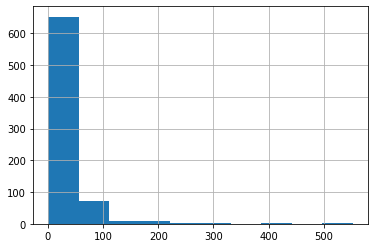

In [ ]:
N = 1000
idx = np.random.choice(users_df.shape[0], N, replace=False)
subgraph_nodes = users_df.index.values[idx].tolist()
users_df.loc[subgraph_nodes].user2_nb.hist()

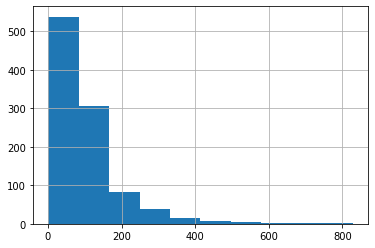

In [4]:
N = 1000
subgraph_nodes = users_df.index.tolist()[:N]
users_df.loc[subgraph_nodes].user2_nb.hist()

**sub graph of N users**

In [5]:
#subgraph = graph[graph.user_1.isin(subgraph_nodes)]

subgraph = graph[graph.isin(
    {'user_1': subgraph_nodes, 'user_2': subgraph_nodes})\
    .all(axis='columns')]

In [6]:
print(subgraph.shape)
print(len(subgraph.user_1.unique()))

(63192, 2)
979


# ratings

In [7]:
rating_with_timestamp = pd.read_csv('/content/drive/My Drive/Social Networks/'
                                    'part_2/rating_with_timestamp.txt',
                                    names=['user_id', 
                                           'product_id', 
                                           'category_id', 
                                           'rating',
                                           'helpfulness',
                                           'time_stamp'],
                                    delim_whitespace=True)

rating_df = pd.DataFrame()
rating_df = rating_with_timestamp[['user_id', 'category_id', 'rating']]
rating_df = rating_df.astype({'user_id': 'int32',
                              'category_id': 'int32',
                              'rating': 'int32'})

print(rating_df.shape)
rating_df.head()

(922267, 3)


,user_id,category_id,rating
0,1,3,2
1,1,2,2
2,1,3,2
3,1,3,5
4,1,3,3


# subset of categories

In [8]:
categories_subset = rating_df.category_id.value_counts().index.tolist()[:5]
print(categories_subset)
rating_df = rating_df[rating_df.category_id.isin(categories_subset)]
print(rating_df.shape)

[3, 4, 5, 19, 10]
(502255, 3)


mean rating for every user and category

In [9]:
user_categoty_group_rating = \
  rating_df.groupby(['user_id', 'category_id']).mean()
user_categoty_group_rating['rating'] = \
  user_categoty_group_rating.rating.apply(lambda v: round(v, 3))





# get the values of the first level index (category_id)
category_ids = user_categoty_group_rating.index.get_level_values('category_id')

# set index just to user_id
user_categoty_group_rating.index = \
  user_categoty_group_rating.index.get_level_values(0)

# put the values of the index into a cilumn
user_categoty_group_rating['category_id'] = category_ids

# re-oreder coumn values
user_categoty_group_rating = user_categoty_group_rating[['category_id', 
                                                         'rating']]




user_ratings = pd.DataFrame()
user_ratings['ratings'] = \
  user_categoty_group_rating\
  .groupby('user_id')\
  .apply(lambda r: dict(zip(r['category_id'], r['rating'])))

print(user_ratings.shape)
user_ratings.head()

(20257, 1)


,ratings
user_id,
1,{3: 2.75}
2,"{3: 3.286, 4: 2.5, 5: 4.5, 10: 4.0}"
3,{10: 5.0}
4,"{3: 4.0, 4: 3.0, 5: 4.111, 10: 3.5}"
5,"{4: 4.5, 19: 4.0}"


# influence probabilities

take out users that have no ratings


In [10]:
print(subgraph.shape)
users_ratings_list = rating_df.user_id.unique().tolist()

subgraph = subgraph[subgraph.isin(
    {'user_1': users_ratings_list, 'user_2': users_ratings_list})\
    .all(axis='columns')]

print(subgraph.shape)

(63192, 2)
(55336, 2)


In [11]:
def influence_probs(user_1, user_2):

  infl_dict = dict()

  # get ratings
  ratings_user1 = user_ratings.loc[user_1].iloc[0]
  ratings_user2 = user_ratings.loc[user_2].iloc[0]

  # get categories that have rated
  user1_categories = set(ratings_user1.keys())
  user2_categories = set(ratings_user2.keys())

  common_categories = user1_categories.intersection(user2_categories)

  # if there are no common categories then there is no influence
  if len(common_categories) == 0:
    return infl_dict

  # avoid division by zero
  eps = 1e-06

  # denominator
  denom = 0
  for cc in common_categories:
    user1_rating = ratings_user1[cc]
    user2_rating = ratings_user2[cc]
    cat_diff = abs(user1_rating - user2_rating)
    if cat_diff == 0:
      denom += 1.0 / eps
    else:
      denom += 1.0 / cat_diff

  # categories of both user_1 and user_2
  categories = user1_categories.union(user2_categories)
  # compute influence probability for every category
  for c in categories:
    if c in user1_categories:
      usr1_rating = ratings_user1[c]
    else:
      usr1_rating = 0
    if c in user2_categories:
      usr2_rating = ratings_user2[c]
    else:
      usr2_rating = 0
    numer = abs(usr1_rating - usr2_rating)
    numer += eps
    numer = 1.0 / numer
    res = round(numer / denom, 3)
    infl_dict[c] = res

  return infl_dict

In [12]:
subgraph['influence_probabilities'] =\
    subgraph.apply(lambda r: influence_probs(r.user_1, r.user_2), axis=1)

subgraph.head()

,user_1,user_2,influence_probabilities
0,9831,19832,{}
3,9831,15698,"{19: 0.2, 4: 1.0, 3: 1.0, 10: 0.333}"
6,9831,4076,"{19: 0.033, 4: 0.905, 3: 0.048, 5: 0.034, 10: ..."
7,9831,2116,"{3: 0.08, 4: 0.171, 5: 0.063, 10: 0.672, 19: 0..."
8,9831,17255,"{19: 0.0, 4: 1.0, 3: 0.0, 5: 0.0, 10: 0.0}"


# reliable set for a category

## create T probabilistic graphs

In [13]:
def keep_edge(influence_probabilities, category):
  rnd_nb = random.uniform(0, 1)
  if influence_probabilities[category] >= rnd_nb:
    return True
  else:
    return False

## reliable set for each node

In [14]:
def user_reliable_set(user):

  # count how many nodes does this node reach
  nodes_reached_dict = dict()

  # for every probabilistic graph
  for idx in range(len(probabilistic_graphs)):

    probabilistic_graph = probabilistic_graphs[idx]

    nodes_reached = list(nx.dfs_preorder_nodes(probabilistic_graph,source=user))

    for nd in nodes_reached:
      if nd in nodes_reached_dict:
        nodes_reached_dict[nd] += 1
      else:
        nodes_reached_dict[nd] = 1

  temp_dict = {k:v for k, v in nodes_reached_dict.items() if v >= majority}
  nodes_reached_dict = temp_dict

  return nodes_reached_dict

## reliable sets for

In [15]:
nb_probabilistic_graphs = 10
majority = math.ceil(nb_probabilistic_graphs / 2)

reliable_sets_category = pd.DataFrame()
reliable_sets_category['user'] = subgraph.user_1.unique()
nodes_list = reliable_sets_category.user.values.tolist()

for category in categories_subset:  

  probabilistic_graphs_list = list()

  for idx in range(nb_probabilistic_graphs):

    subgraph_category = subgraph[subgraph\
                                .influence_probabilities\
                                .apply(lambda v: category in v.keys())]

    subgraph_category['keep_edge'] = subgraph_category.apply(
        lambda r: keep_edge(r.influence_probabilities, category), axis=1)
    
    subgraph_category = subgraph_category[subgraph_category.keep_edge]

    probabilistic_graphs_list.append(subgraph_category)


  probabilistic_graphs = list()

  for pg in probabilistic_graphs_list:

    p_graph = nx.DiGraph()
    p_graph.add_nodes_from(nodes_list)
    p_graph.add_edges_from(list(zip(pg['user_1'], pg['user_2'])))

    probabilistic_graphs.append(p_graph)

  reliable_sets_category['reliable_set_c_{}'.format(category)] = \
      reliable_sets_category.user.apply(user_reliable_set)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
reliable_sets_category.head()

,user,reliable_set_c_3,reliable_set_c_4,reliable_set_c_5,reliable_set_c_19,reliable_set_c_10
0,9831,"{9831: 10, 15698: 10, 9597: 10, 1502: 10, 2130...","{9831: 10, 15698: 10, 9597: 10, 16780: 10, 667...","{9831: 10, 19950: 10, 7472: 10, 5627: 10, 1688...","{9831: 10, 3557: 10, 14311: 10, 9597: 10, 9370...","{9831: 10, 2116: 10, 16886: 10, 505: 10, 6675:..."
1,5369,"{5369: 10, 12037: 10, 14921: 10, 21094: 10, 74...","{5369: 10, 9222: 10, 19536: 10, 5627: 10, 2023...","{5369: 10, 5420: 9, 5550: 9, 12037: 9, 796: 9,...","{5369: 10, 19885: 10, 2023: 10, 7479: 10, 2318...","{5369: 10, 19896: 10, 13379: 10, 3957: 10, 937..."
2,6876,"{6876: 10, 11561: 10, 8006: 10, 14644: 10, 130...","{6876: 10, 9597: 10, 16780: 10, 6675: 10, 505:...","{6876: 10, 9597: 10, 5627: 10, 16886: 10, 1678...","{6876: 10, 19950: 10, 19896: 10, 5963: 10, 160...","{6876: 10, 15393: 10, 10465: 10, 1715: 10, 141..."
3,2760,"{2760: 10, 9140: 10, 7472: 10, 1715: 10, 4245:...","{2760: 10, 13657: 10, 1464: 10, 19482: 10, 937...","{2760: 10, 9140: 9, 2318: 10, 7535: 10, 6143: ...","{2760: 10, 9738: 10, 19482: 10, 1715: 10, 1415...","{2760: 10, 9140: 10, 2318: 10, 7535: 10, 2023:..."
4,20240,"{20240: 10, 1234: 10, 14860: 10, 18555: 10, 18...","{20240: 10, 4076: 10, 14286: 10, 9370: 10, 210...","{20240: 10, 1896: 10, 3957: 10, 13379: 10, 107...","{20240: 10, 1464: 10, 19482: 10, 1715: 10, 141...","{20240: 10, 7965: 10, 16330: 10, 7606: 10, 115..."


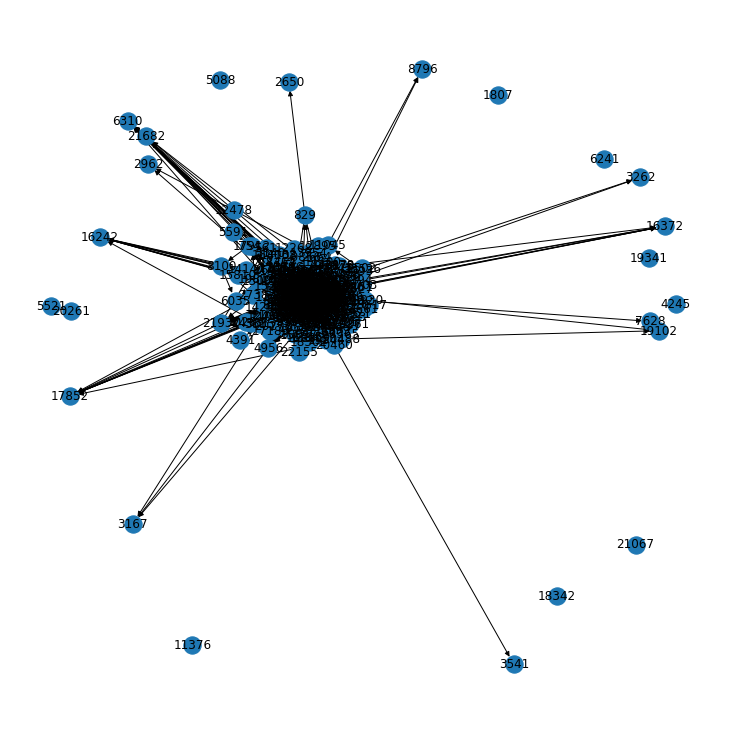

In [ ]:
import matplotlib.pyplot as plt

# fixing the size of the figure 
plt.figure(figsize =(10, 10))
nx.draw(pg, with_labels=True)

# reliable sets overlaps

In [17]:
users = np.sort(reliable_sets_category.user.values).tolist()

users_combs = pd.Series(combinations(users, 2))

overlaps_df = pd.DataFrame(data=users_combs, columns=['users_combinations'])

print(overlaps_df.shape)
overlaps_df.head()

(405450, 1)


,users_combinations
0,"(29, 40)"
1,"(29, 53)"
2,"(29, 61)"
3,"(29, 62)"
4,"(29, 64)"


In [18]:
def pair_overlap(users_combinations):

  user_1 = users_combinations[0]
  user_2 = users_combinations[1]

  rss_user1 = reliable_sets_category[reliable_sets_category.user==user_1]
  rss_user2 = reliable_sets_category[reliable_sets_category.user==user_2]



  user_1_categories = list()
  for rv in rss_user1.items():
    dct = rv[1].iloc[0]
    user_1_categories.append(dct)
  user_1_categories = user_1_categories[1:]

  user_2_categories = list()
  for rv in rss_user2.items():
    dct = rv[1].iloc[0]
    user_2_categories.append(dct)
  user_2_categories = user_2_categories[1:]

  categories_overlaps = dict()
  idx = 1
  for u1c in user_1_categories:
    u1rs = set(u1c.keys())
    for u2c in user_2_categories:
      u2rs = set(u2c.keys())
      ovl = u1rs.intersection(u2c)
      categories_overlaps[idx] = len(ovl)
      idx += 1

  return categories_overlaps

In [19]:
overlaps_df['overlaps'] = overlaps_df.users_combinations.apply(pair_overlap)

In [20]:
overlaps_df.head()

,users_combinations,overlaps
0,"(29, 40)","{1: 761, 2: 711, 3: 683, 4: 662, 5: 713, 6: 70..."
1,"(29, 53)","{1: 761, 2: 711, 3: 683, 4: 674, 5: 663, 6: 70..."
2,"(29, 61)","{1: 761, 2: 711, 3: 683, 4: 674, 5: 713, 6: 70..."
3,"(29, 62)","{1: 761, 2: 711, 3: 648, 4: 674, 5: 713, 6: 70..."
4,"(29, 64)","{1: 761, 2: 711, 3: 683, 4: 674, 5: 713, 6: 70..."


In [ ]:
# save DataFrame

overlaps_df.to_pickle('/content/drive/My Drive/Social Networks/'
'saved_DataFrames/overlaps.pkl')

# F(n,u,v)

In [21]:
# list with matrices for every category
matrix_list = list()

users = np.sort(reliable_sets_category.user.values).tolist()
nb_users = len(users)

for c in categories_subset:
  c_r_u_v_a = np.zeros([nb_users, nb_users]).astype(int)
  for idx, user_1 in enumerate(users):
    # reliable set of user 1 for category c
    rs = reliable_sets_category[reliable_sets_category.user==user_1]['reliable_set_c_{}'.format(c)].iloc[0]
    rsl = list(rs.keys())
    # if user 2 is in user 1 reliable set for this category then the
    # corresponding array cell will be 1
    for idx_in, user_2 in enumerate(users):
      if user_2 in rsl:
        c_r_u_v_a[idx, idx_in] = 1  
  np.fill_diagonal(c_r_u_v_a, 0)
  matrix_list.append(c_r_u_v_a)

In [22]:
np.sum(matrix_list[1],axis=1)

array([716, 754, 754, 754, 754, 754, 754, 754, 754,   0,   0, 754, 754,
       754, 754, 726, 754, 754,   0, 754, 754, 754, 754, 754, 754, 750,
       754, 754, 754, 754, 754, 754, 754, 754, 754, 754,   0, 754, 754,
       754, 754, 754,   0, 755, 754, 754, 754, 754,   0, 754, 754, 754,
       754,   0, 754, 754, 754, 755, 754, 742, 754, 754, 754, 754, 754,
       754, 754,   0, 754, 754,   0, 754, 754, 754, 754, 754, 754, 754,
       754, 755, 754, 748, 754, 754, 754, 754, 754, 754, 754,   0, 754,
       754, 754, 754, 754, 754, 754,   0, 754, 754, 754, 754, 754, 754,
       754, 754, 754,   0,   0, 754, 754, 754, 754, 754, 754, 754, 751,
       754, 754, 754, 754, 754, 754, 708,   0, 755, 754, 754, 754, 754,
       754,   0, 754, 754, 714, 754, 754, 754,   0, 754,   0, 755, 754,
       731, 754, 754, 754, 754, 754,   0, 754, 754, 754, 754, 754, 754,
       754, 754, 754, 754, 754, 754, 754, 748, 754, 754, 754, 754, 754,
       754, 748,   0, 754, 754, 754, 754, 754, 754, 754, 754, 75